# Visual Vector Search

## 0. Prerequisites
Before we begin, we must install the required libraries.

In [ ]:
!pip install sentence-transformers redis img2vec-pytorch

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Connect to Redis server
Replace the connection params below with your own if you are connecting to an external Redis instance.

In [3]:
import redis

# Redis connection params
redis_url = "redis://redis-12000.cluster.dev-vss.demo.redislabs.com:12000"

# Create Redis client
redis_client = redis.from_url(redis_url)

# Test connection
redis_client.ping()

True

In [108]:
# Clear Redis database (optional)
redis_client.flushdb()

True

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## 1. Vector Storage

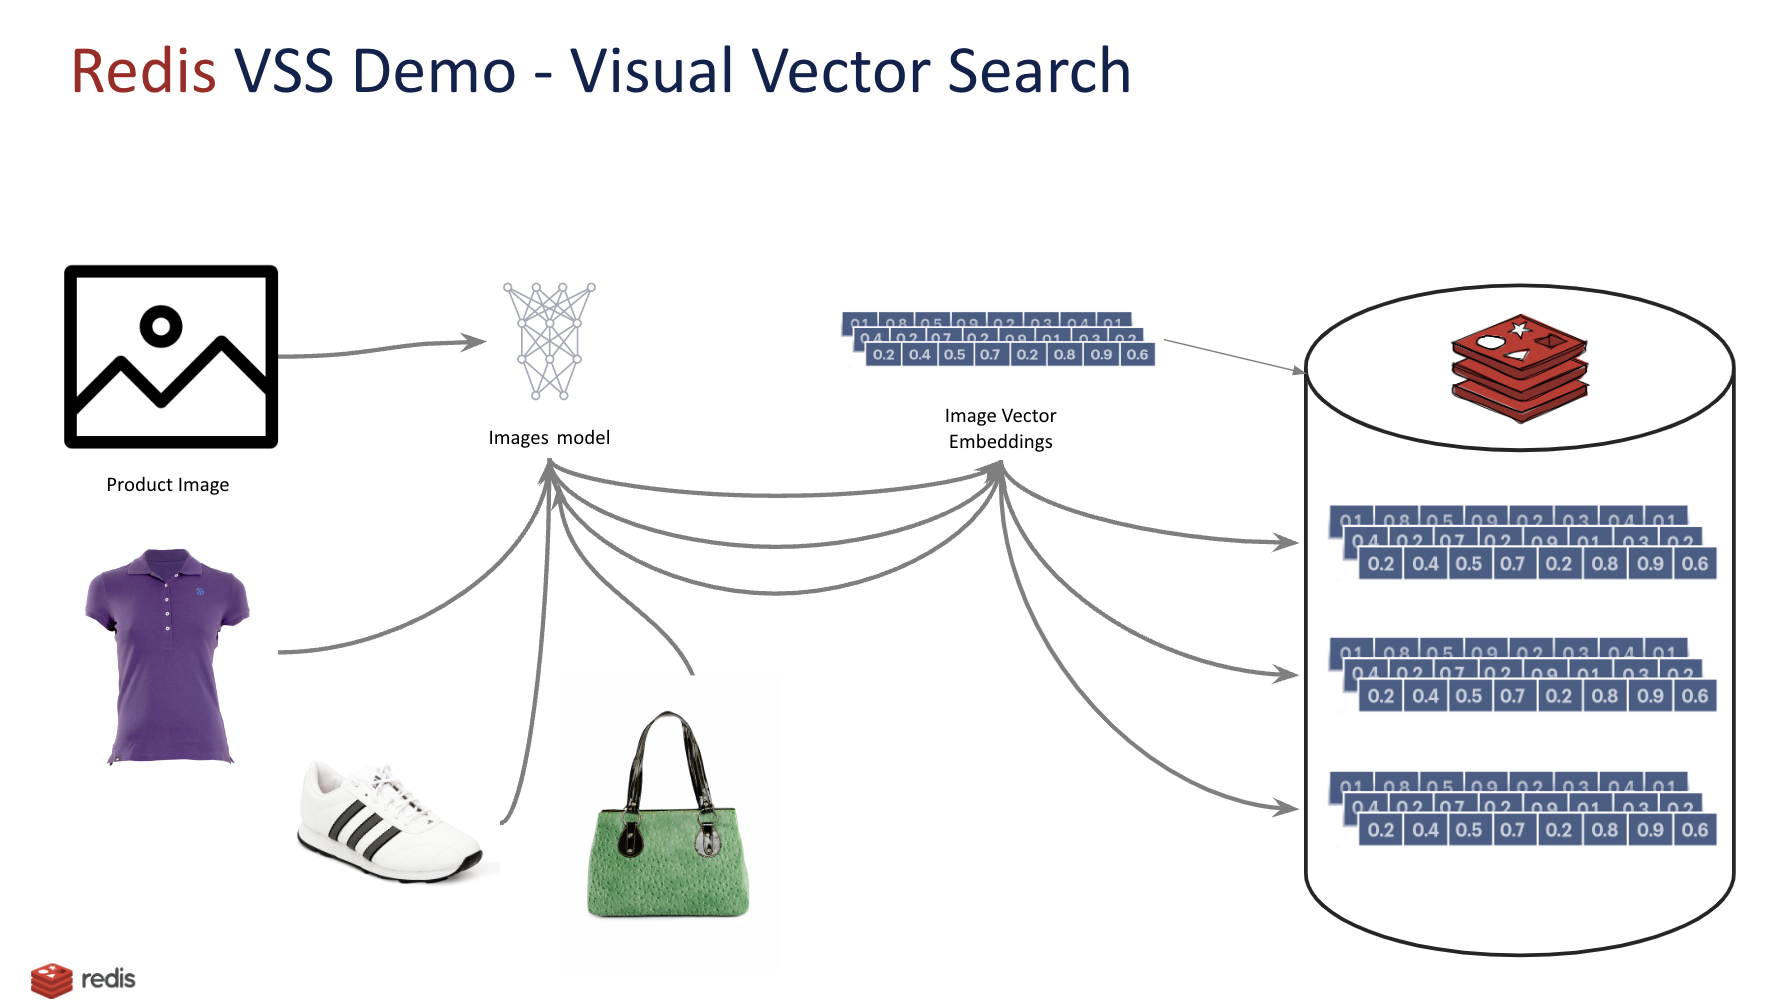

In [139]:
from PIL import Image
from typing import Generator, List, Any
from img2vec_pytorch import Img2Vec
from glob import glob
import matplotlib.pyplot as plt

import os
import redis

# data prep
import pandas as pd
import numpy as np
# for creating image vector embeddings
import urllib.request


def generate_image_vector(file):
   # Resnet-18 to create image embeddings
   image_model = Img2Vec()
   img = Image.open(file).convert('RGB')
   img = img.resize((224, 224))
   return image_model.get_vec(img)

# Convert embeddings to bytes for Redis storage
def convert_embedding(emb: List[float]):
  return np.array(emb).astype(np.float32).tobytes()

# Create Dataframes from image folder
def create_image_dataframe(folder, tag_name, tag):

  myDict = {
      'product_id' : [],
      'product_embedding' : [],
      'product_image_url' : [],
      tag_name : []
  }

  dir = os.path.join(f"{folder}/{tag}", "*.jpg")
  for file in glob(dir):
    id = os.path.splitext(os.path.basename(file))[0]
    myDict['product_id'].append(id)
    myDict['product_embedding'].append(convert_embedding(generate_image_vectors(file)))
    myDict[tag_name].append(tag)
    myDict['product_image_url'].append(file)

  df = pd.DataFrame(myDict)
  return df

# display product image
def display_product(file):
  img = Image.open(file).convert('RGB')
  img = img.resize((224, 224))
  plt.imshow(img)
  plt.show()

In [140]:
df_men = create_image_dataframe("drive/MyDrive/ColabDrive/products", "gender", "men")
df_women = create_image_dataframe("drive/MyDrive/ColabDrive/products", "gender", "women")

df = pd.concat([df_men, df_women])

display(df)

,product_id,product_embedding,product_image_url,gender
0,b3d19377041615d8a7cf46b96ef67c4c,b'BJ\x07@\xa8\t\r@4\xfcB>\xe6\xa8\xec<\xd4\x97...,drive/MyDrive/ColabDrive/products/men/b3d19377...,men
1,7185ef5d96833937481c19a47edac96a,b'\x10\xa3\xb0?\xc7(\xf4?\xc5[:>;\xf5]:\xc8rQ>...,drive/MyDrive/ColabDrive/products/men/7185ef5d...,men
2,6d62ba4de5c73b36d44f6bff05d2457e,b'\x8dR\x17@;\xd2\x93?\x8f\x98\xa0?i~\xa0=\xc5...,drive/MyDrive/ColabDrive/products/men/6d62ba4d...,men
3,8cf52572340c3592e5f0ede116a0206f,"b'*2C@\x94\x19,?\xe3\xcb\x9a?\xcda\xd1>\x9e\xe...",drive/MyDrive/ColabDrive/products/men/8cf52572...,men
4,393e9315126350d97000721f330aa964,b'h\xc0I@\t\n\x10?\x99Y\x96?}\xe6U=\x07\x80\x1...,drive/MyDrive/ColabDrive/products/men/393e9315...,men
5,2eca615a43d0098f4bb5fc90004c3678,"b'\xaf\x92(@\x89Vg?\xf6\xf5\xc9?,K\x96>\x85\xf...",drive/MyDrive/ColabDrive/products/men/2eca615a...,men
0,88046aefb3d87ea8418c12f6f48717fa,b'?5\xa1?\xa3\xdaz?\'\ri>\x0e\x88\x8b?\xea\xe5...,drive/MyDrive/ColabDrive/products/women/88046a...,women
1,ec28a6e80636805d0bf993699b656c88,b'\x1f\xa9\xee?\x9d\'\xf9>\x9a\xd0j?s\xa7\xc1=...,drive/MyDrive/ColabDrive/products/women/ec28a6...,women
2,7ce41800565e35b1c3603642e4b8725f,b'\x9e\xea\xe0?\x03;^?\x1b\xbfM>\xf5\xc2\x17?*...,drive/MyDrive/ColabDrive/products/women/7ce418...,women
3,9f70a44e8105afd42debd1302a5149df,b'\x00\xbc\xc0?\xa6\x98\x96?\xe8<\x94>Y\'\x9c<...,drive/MyDrive/ColabDrive/products/women/9f70a4...,women


In [141]:
import json

for index, row in df.iterrows():
  redis_client.hset(f"product:{row['product_id']}", mapping={"product_id": row['product_id'], "product_embedding": row['product_embedding'], "product_image_url": row["product_image_url"], "gender": row['gender']})

## 2. Vector Indexing
After creating embeddings that represent the products and storing them in Redis, we will create a secondary index that enables efficient search over the embeddings. To learn more about the vector similarity features in Redis, [check out these docs](https://redis.io/docs/interact/search-and-query/search/vectors/) and [these Redis AI resources](https://github.com/RedisVentures/redis-ai-resources).


In [142]:
from redis.commands.search.field import (
    TagField,
    VectorField,
)

from redis.commands.search.indexDefinition import (
    IndexDefinition,
    IndexType
)

# Function to create a FLAT search index with Redis/RediSearch
def create_flat_index(
    redis_conn,
    vector_field_name: str,
    number_of_vectors: int,
    index_name:str,
    prefix: str,
    distance_metric: str='COSINE'
):
    # Construct index
    try:
        redis_client.ft(index_name).info()
        print("Existing index found. Dropping and recreating the index", flush=True)
        redis_client.ft(index_name).dropindex(delete_documents=False)
    except:
        print("Creating new index", flush=True)

    image_field = VectorField(f"{vector_field_name}", "FLAT",
                {
                    "TYPE": "FLOAT32",
                    "DIM": 512,
                    "DISTANCE_METRIC": distance_metric,
                    "INITIAL_CAP": number_of_vectors
                })

    redis_conn.ft(index_name).create_index(
        fields = [image_field],
        definition = IndexDefinition(prefix=[prefix], index_type=IndexType.HASH)
    )

In [143]:
# Create an FLAT search index for the products created earlier.
create_flat_index(redis_client, "product_embedding", 3, "product_index",'product:')

Creating new index


## 3. Vector Querying
Let's choose a product's image (query image) and calculate its distance (similarity) with the product created previously.

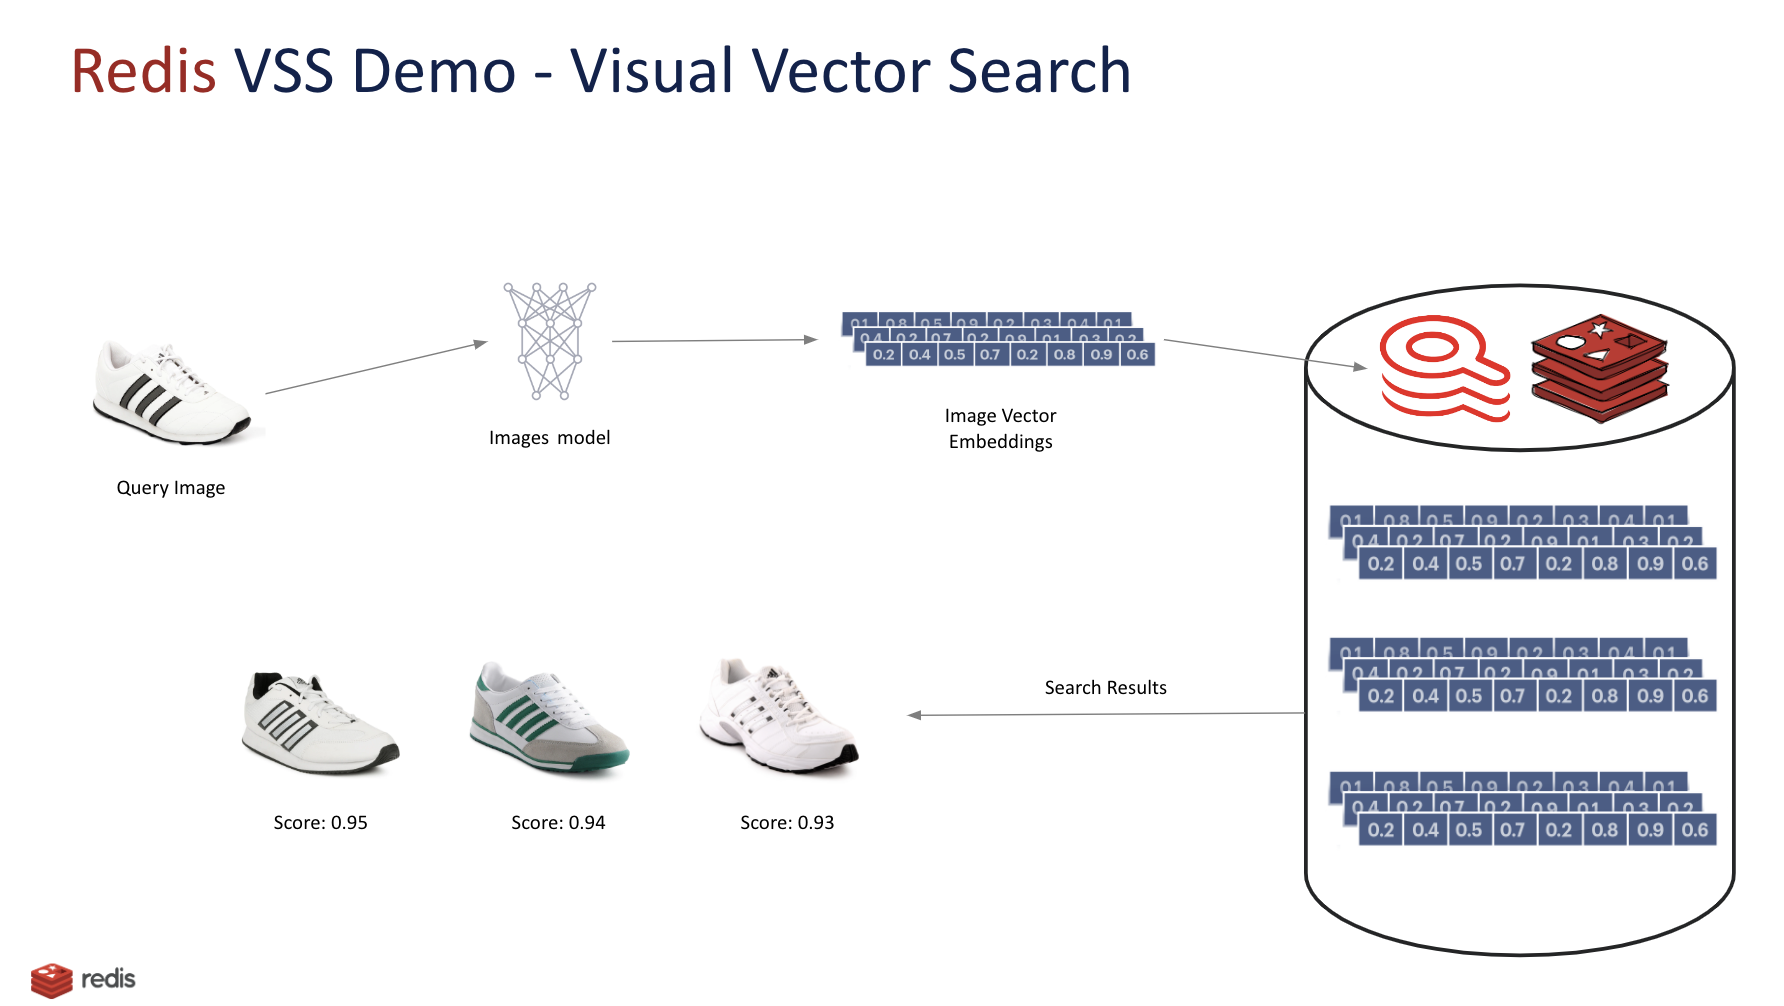

In [144]:
# 1. Create query vector
query_image = "drive/MyDrive/ColabDrive/products/men/2eca615a43d0098f4bb5fc90004c3678.jpg"

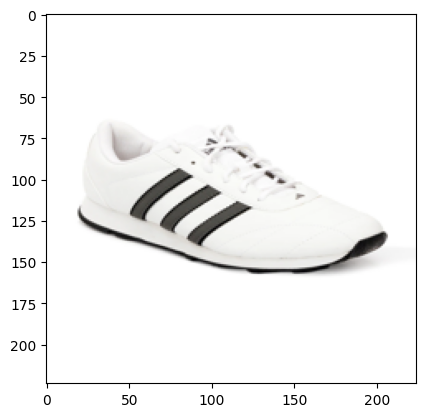

In [145]:
display_product(query_image)

### Define a helper function to perform the KNN similarity search

We define a helper function, `similarity_search`, to create an embedding from the query image and compare it to other vectors having the same prefix according to the index created previously.

In [157]:
from redis.commands.search.query import Query
import pandas as pd

# Helper method to perform KNN similarity search in Redis
def similarity_search(query_image: str, k: int, return_fields: tuple, index_name: str = "product_index") -> list:
    # create redis query object
    redis_query = (
        Query(f"*=>[KNN {k} @product_embedding $product_embedding AS distance]")
            .sort_by("distance")
            .return_fields(*return_fields)
            .paging(0, k)
            .dialect(2)
    )
    # create embedding from query text
    query_vector = generate_image_vector(query_image)

    # execute the search
    results = redis_client.ft(index_name).search(
        redis_query, query_params={"product_embedding": convert_embedding(query_vector)}
    )
    return pd.DataFrame([t.__dict__ for t in results.docs]).drop(columns=["payload"])

In [158]:
# 2. Perform vector similarity search with given query
results = similarity_search(query_image, k=3, return_fields=("distance", "product_image_url",	"product_id", "gender"))
results['score'] = 1 - results['distance'].astype('float64')
display(results.sort_values("score", ascending=False).drop(columns=["distance"]))


,id,product_image_url,product_id,gender,score
0,product:2eca615a43d0098f4bb5fc90004c3678,drive/MyDrive/ColabDrive/products/men/2eca615a...,2eca615a43d0098f4bb5fc90004c3678,men,1.000000
1,product:393e9315126350d97000721f330aa964,drive/MyDrive/ColabDrive/products/men/393e9315...,393e9315126350d97000721f330aa964,men,0.954971
2,product:8cf52572340c3592e5f0ede116a0206f,drive/MyDrive/ColabDrive/products/men/8cf52572...,8cf52572340c3592e5f0ede116a0206f,men,0.942790


Product 2eca615a43d0098f4bb5fc90004c3678 - Gender men - Score 0.9999999403953552


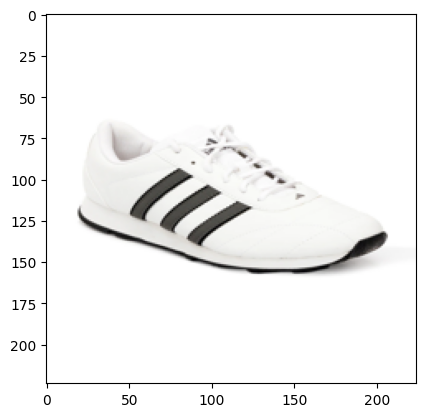

Product 393e9315126350d97000721f330aa964 - Gender men - Score 0.9549709558487


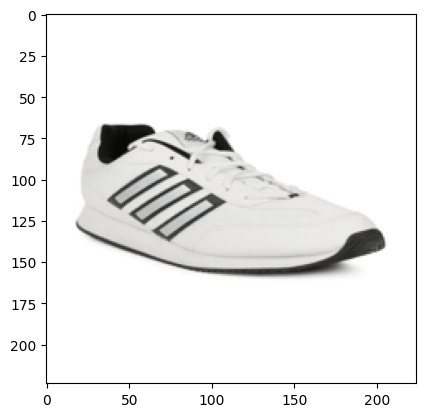

Product 8cf52572340c3592e5f0ede116a0206f - Gender men - Score 0.942790210247


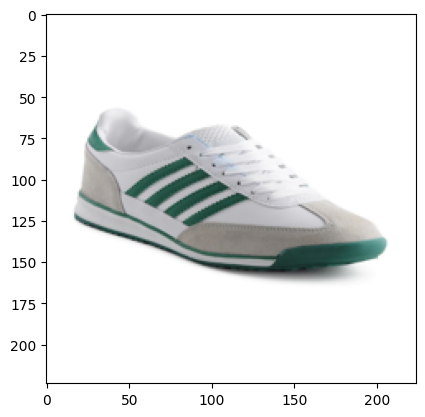

In [153]:
for index, row in results.iterrows():
  print(f"Product {row['product_id']} - Gender {row['gender']} - Score {row['score']}")
  display_product(row['product_image_url'])

# Hybrid Search

Now, we will try to create a secondary index that enables hybrid search over the image embeddings and other fields like `gender` for example.

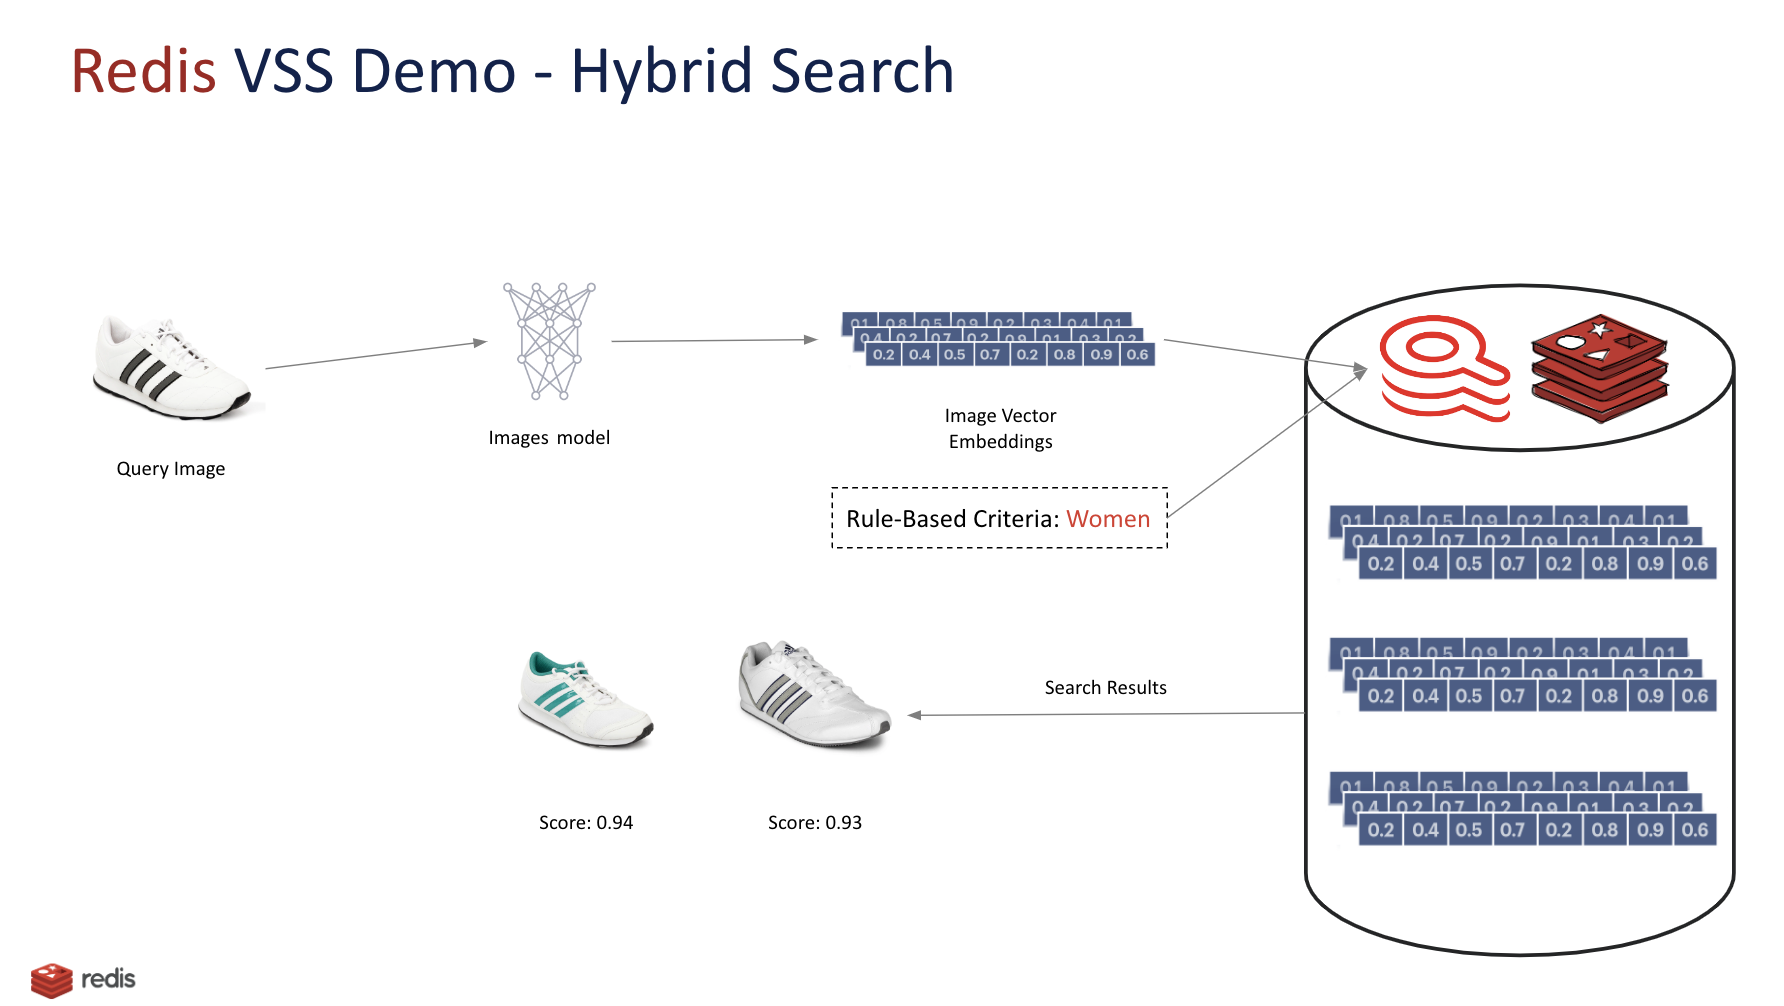

In [155]:
from redis.commands.search.field import (
    TagField,
    VectorField,
)

from redis.commands.search.indexDefinition import (
    IndexDefinition,
    IndexType
)

# Function to create a hybrid search index with Image Vector Search + Tag Filtering
def create_hybrid_index(
    redis_conn,
    vector_field_name: str,
    tag_field_name: str,
    number_of_vectors: int,
    index_name:str,
    prefix: str,
    distance_metric: str='COSINE'
):
    # Construct index
    try:
        redis_client.ft(index_name).info()
        print("Existing index found. Dropping and recreating the index", flush=True)
        redis_client.ft(index_name).dropindex(delete_documents=False)
    except:
        print("Creating new index", flush=True)

    tag_field = TagField(f"{tag_field_name}")

    image_field = VectorField(f"{vector_field_name}", "FLAT",
                {
                    "TYPE": "FLOAT32",
                    "DIM": 512,
                    "DISTANCE_METRIC": distance_metric,
                    "INITIAL_CAP": number_of_vectors
                })

    redis_conn.ft(index_name).create_index(
        fields = [image_field, tag_field],
        definition = IndexDefinition(prefix=[prefix], index_type=IndexType.HASH)
    )

In [156]:
# 1. Create a hybrid search index for the products created earlier.
create_hybrid_index(redis_client, "product_embedding", "gender", 3, "product_index",'product:')

Existing index found. Dropping and recreating the index


We create another helper function, called `hybrid_similarity_search` to create an embedding from the query image and compare it to other vectors having the same prefix according to the index created previously, in addition to the filtering by the query tag.

In [179]:
# Helper method to perform KNN similarity search in Redis
def hybrid_similarity_search(query_image: str, query_tag: str, k: int, return_fields: tuple, index_name: str = "product_index") -> list:
    # create redis query object
    redis_query = (
        Query(f"(@gender:{{{query_tag}}})=>[KNN {k} @product_embedding $product_embedding AS distance]")
            .sort_by("distance")
            .return_fields(*return_fields)
            .paging(0, k)
            .dialect(2)
    )
    # create embedding from query text
    query_vector = generate_image_vector(query_image)

    # execute the search
    results = redis_client.ft(index_name).search(
        redis_query, query_params={"product_embedding": convert_embedding(query_vector)}
    )
    return pd.DataFrame([t.__dict__ for t in results.docs]).drop(columns=["payload"])

Now we will query the index with the query image and the query tag.

In [161]:
# 2. Create query vector
query_image = "drive/MyDrive/ColabDrive/products/men/2eca615a43d0098f4bb5fc90004c3678.jpg"
query_tag = "women"

In [180]:
# 3. Perform the hybrid vector similarity search with the given parameters

results = hybrid_similarity_search(query_image, query_tag, k=3, return_fields=("distance", "product_image_url",	"product_id", "gender"))
results['score'] = 1 - results['distance'].astype('float64')
display(results.sort_values("score", ascending=False).drop(columns=["distance"]))

,id,product_image_url,product_id,gender,score
0,product:a27cf465dade1e9dfe146683f696d57f,drive/MyDrive/ColabDrive/products/women/a27cf4...,a27cf465dade1e9dfe146683f696d57f,women,0.926042
1,product:7ce41800565e35b1c3603642e4b8725f,drive/MyDrive/ColabDrive/products/women/7ce418...,7ce41800565e35b1c3603642e4b8725f,women,0.886814
2,product:a9d1eabd2f40affad56623f15ad76083,drive/MyDrive/ColabDrive/products/women/a9d1ea...,a9d1eabd2f40affad56623f15ad76083,women,0.884039


Product a27cf465dade1e9dfe146683f696d57f - Gender women - Score 0.9260421395302


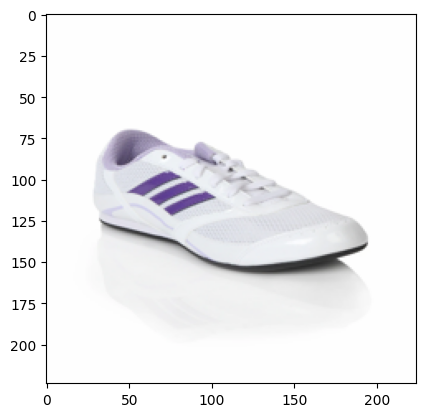

Product 7ce41800565e35b1c3603642e4b8725f - Gender women - Score 0.886814296246


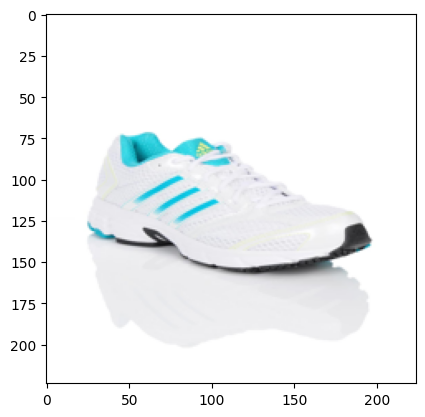

Product a9d1eabd2f40affad56623f15ad76083 - Gender women - Score 0.884038686752


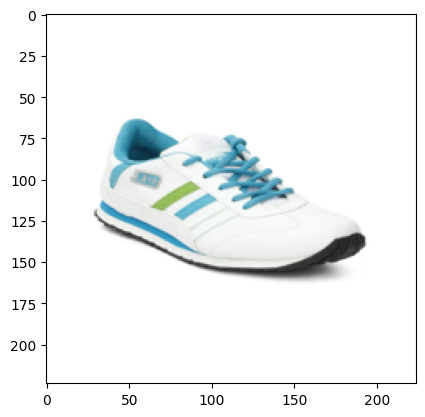

In [181]:
for index, row in results.iterrows():
  print(f"{index}- Product {row['product_id']} - Gender {row['gender']} - Score {row['score']}")
  display_product(row['product_image_url'])